In [1]:
from comet_ml import Experiment

In [11]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [12]:
# Load dataset
df = pd.read_csv('/home/lagvna/Pobrane/UrbanSound8K/metadata/UrbanSound8K.csv')# Create a list of the class labels
labels = list(df['class'].unique())# Let's grab a single audio file from each class
files = dict()
for i in range(len(labels)):
    tmp = df[df['class'] == labels[i]][:1].reset_index()
    path = '/home/lagvna/Pobrane/UrbanSound8K/audio/fold{}/{}'.format(tmp['fold'][0], tmp['slice_file_name'][0])
    files[labels[i]] = path

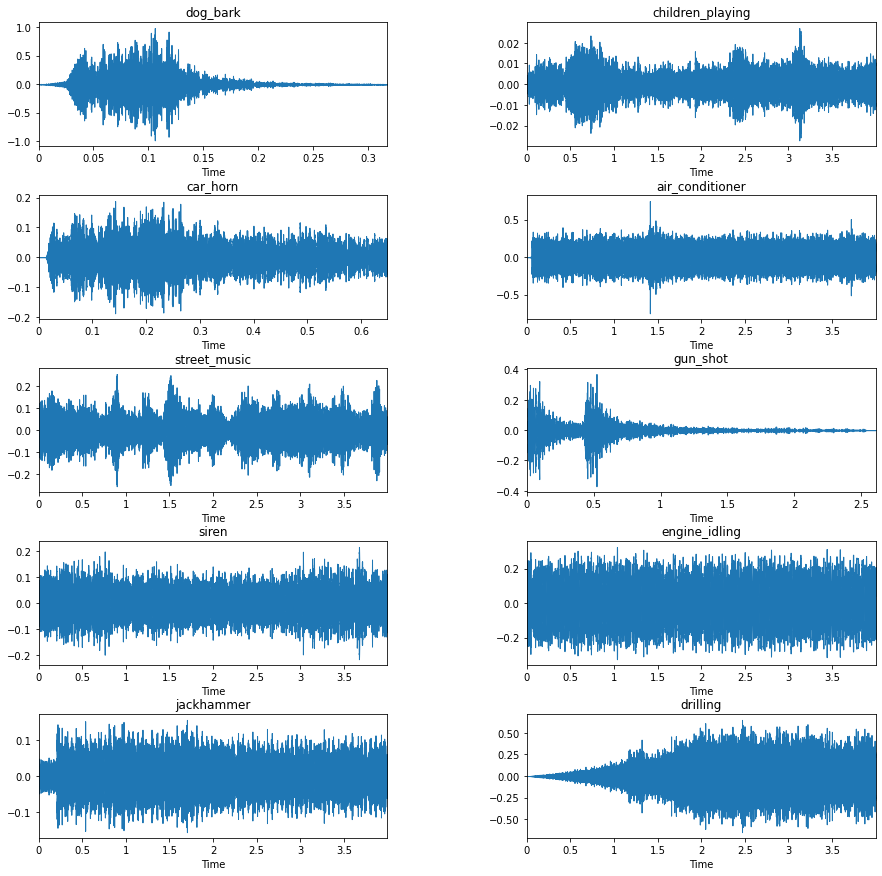

In [13]:
fig = plt.figure(figsize=(15,15))# Log graphic of waveforms to Comet
#experiment.log_image('class_examples.png')
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    fn = files[label]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fn)
    librosa.display.waveplot(data, sr= sample_rate)
plt.savefig('class_examples.png')

In [14]:
fn = '/home/lagvna/Pobrane/UrbanSound8K/audio/fold1/191431-9-0-66.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)

print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 48000
Librosa sample rate: 22050


In [16]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -1869 to 1665
Librosa audio file min~max range: -0.05 to -0.05


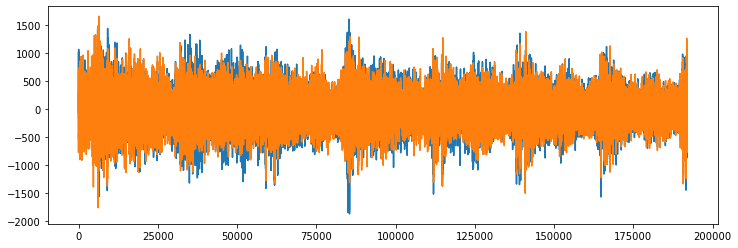

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)
plt.savefig('original_audio.png')
#experiment.log_image('original_audio.png')

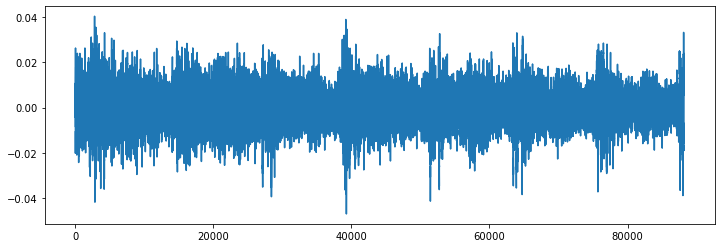

In [18]:
# Librosa: mono track
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)
plt.savefig('librosa_audio.png')
#experiment.log_image('librosa_audio.png')

In [19]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 40)

In [20]:
print(mfccs.shape)

(40, 173)


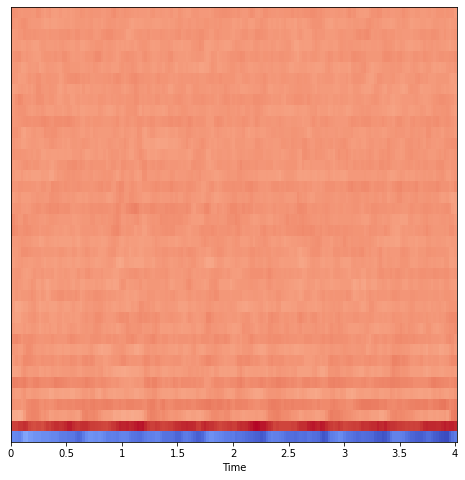

In [21]:
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
plt.savefig('MFCCs.png')
#experiment.log_image('MFCCs.png')

In [22]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
     
    return mfccs_processed

In [26]:
import os

fulldatasetpath = '/home/lagvna/Pobrane/UrbanSound8K/audio/'

metadata = df

features = []
# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

/home/lagvna/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
/home/lagvna/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
/home/lagvna/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


In [27]:
featuresdf.head()

,feature,class_label
0,"[-215.79301, 71.66612, -131.81377, -52.091328,...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01073, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265694,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.608585, 1....",children_playing


In [28]:
featuresdf.iloc[0]['feature']

array([-2.1579301e+02,  7.1666122e+01, -1.3181377e+02, -5.2091328e+01,
       -2.2115967e+01, -2.1764179e+01, -1.1183748e+01,  1.8912683e+01,
        6.7266388e+00,  1.4556895e+01, -1.1782046e+01,  2.3010371e+00,
       -1.7251303e+01,  1.0052422e+01, -6.0094995e+00, -1.3153189e+00,
       -1.7693510e+01,  1.1171218e+00, -4.3699460e+00,  7.2629523e+00,
       -1.1815970e+01, -7.4952612e+00,  5.4577117e+00, -2.9442449e+00,
       -5.8693886e+00, -9.8653756e-02, -3.2121708e+00,  4.6092505e+00,
       -5.8293276e+00, -5.3475084e+00,  1.3341198e+00,  7.1307821e+00,
       -7.9450049e-02,  1.7109241e+00, -5.6942000e+00, -2.9041715e+00,
        3.0366955e+00, -1.6827594e+00, -8.8585883e-01,  3.5438937e-01],
      dtype=float32)

In [30]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [31]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

In [43]:
num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

# %% In [34]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# %% In [35]:
experiment.log_parameter('number_layers', len(model.layers))

# %% In [36]:
# Display model architecture summary 
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               10496     
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_16 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)               

In [44]:
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

In [45]:
print("Pre-training accuracy: %.4f%%" % accuracy)

Pre-training accuracy: 3.8924%


In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
num_epochs = 100
num_batch_size = 32
model.fit(x_train, y_train, batch_size=num_batch_size, 
          epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
219/219 [==============================] - 0s 2ms/step - loss: 8.1059 - accuracy: 0.1946 - val_loss: 2.1562 - val_accuracy: 0.2330
Epoch 2/100
219/219 [==============================] - 0s 2ms/step - loss: 2.2472 - accuracy: 0.2513 - val_loss: 2.0154 - val_accuracy: 0.3131
Epoch 3/100
219/219 [==============================] - 0s 2ms/step - loss: 2.0090 - accuracy: 0.3072 - val_loss: 1.8689 - val_accuracy: 0.3829
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 1.8509 - accuracy: 0.3460 - val_loss: 1.6804 - val_accuracy: 0.4539
Epoch 5/100
219/219 [==============================] - 0s 2ms/step - loss: 1.7444 - accuracy: 0.3847 - val_loss: 1.5512 - val_accuracy: 0.4722
Epoch 6/100
219/219 [==============================] - 0s 2ms/step - loss: 1.6220 - accuracy: 0.4170 - val_loss: 1.4423 - val_accuracy: 0.5352
Epoch 7/100
219/219 [==============================] - 1s 3ms/step - loss: 1.5122 - accuracy: 0.4743 - val_loss: 1.3394 - val_accuracy: 0.5627

Epoch 58/100
219/219 [==============================] - 0s 2ms/step - loss: 0.5903 - accuracy: 0.7983 - val_loss: 0.4884 - val_accuracy: 0.8540
Epoch 59/100
219/219 [==============================] - 0s 2ms/step - loss: 0.5997 - accuracy: 0.7983 - val_loss: 0.4964 - val_accuracy: 0.8460
Epoch 60/100
219/219 [==============================] - 0s 2ms/step - loss: 0.6019 - accuracy: 0.7953 - val_loss: 0.4994 - val_accuracy: 0.8540
Epoch 61/100
219/219 [==============================] - 0s 2ms/step - loss: 0.5705 - accuracy: 0.8034 - val_loss: 0.5001 - val_accuracy: 0.8472
Epoch 62/100
219/219 [==============================] - 0s 2ms/step - loss: 0.5758 - accuracy: 0.8073 - val_loss: 0.4896 - val_accuracy: 0.8609
Epoch 63/100
219/219 [==============================] - 0s 2ms/step - loss: 0.5944 - accuracy: 0.7991 - val_loss: 0.4965 - val_accuracy: 0.8569
Epoch 64/100
219/219 [==============================] - 0s 2ms/step - loss: 0.5817 - accuracy: 0.8072 - val_loss: 0.4784 - val_accuracy:

In [48]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 92.50%
Testing Accuracy: 87.41%
